# Attrition Prediction project

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

import shap
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# notebook environment with helper display tools:
try:
    from caas_jupyter_tools import display_dataframe_to_user
    have_display = True
except Exception:
    have_display = False


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

import shap
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# notebook environment with helper display tools:
try:
    from caas_jupyter_tools import display_dataframe_to_user
    have_display = True
except Exception:
    have_display = False


In [3]:
DATA_PATH = r"C:\Users\VIVEK\Downloads\HR-AttritionRaw.csv"
assert os.path.exists(DATA_PATH), f"File not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded:", df.shape)
print(df.columns.tolist())
if have_display:
    display_dataframe_to_user("Dataset head", df.head(10))
else:
    display(df.head())


Loaded: (1470, 35)
['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
lower_cols = [c.lower() for c in df.columns]
target_candidates = []
keywords = ["attrit", "resign", "left", "turnover", "separat", "resigned", "status"]
for i,c in enumerate(lower_cols):
    for kw in keywords:
        if kw in c:
            target_candidates.append(df.columns[i])

if target_candidates:
    target_col = target_candidates[0]
else:
    # fallback: any binary column with 2 unique values
    bin_cols = [c for c in df.columns if df[c].nunique() == 2]
    target_col = bin_cols[0] if bin_cols else None

if target_col is None:
    raise ValueError("No obvious target column found. Please specify `target_col` manually, e.g. target_col='Attrition'")

print("Using target column:", target_col)

# Map common textual answers to 0/1
def map_target(series):
    s = series.astype(str).str.strip().str.lower()
    pos = s.isin(["yes","y","true","t","1","resigned","left"])
    neg = s.isin(["no","n","false","f","0","active","current","employed","staying"])
    mapped = pd.Series(np.where(pos,1, np.where(neg,0, np.nan)), index=series.index)
    if mapped.isna().all():
        # label-encode everything
        le = LabelEncoder()
        return pd.Series(le.fit_transform(series.fillna("MISSING")), index=series.index)
    return mapped.fillna(0).astype(int)

df["_target_attrition"] = map_target(df[target_col])
print(df["_target_attrition"].value_counts())


Using target column: Attrition
_target_attrition
0    1233
1     237
Name: count, dtype: int64


Rows: 1470
Missing per column (top 10):
Age                 0
Attrition           0
BusinessTravel      0
DailyRate           0
Department          0
DistanceFromHome    0
Education           0
EducationField      0
EmployeeCount       0
EmployeeNumber      0
dtype: int64
Attrition by department:
                         count  attritions      rate
Department                                         
Sales                     446          92  0.206278
Human Resources            63          12  0.190476
Research & Development    961         133  0.138398
Attrition by salary band:
 _salary_band
Low         0.292683
Mid-Low     0.142077
Mid-High    0.106267
High        0.103261
Name: _target_attrition, dtype: float64
                   count      mean
PercentSalaryHike                 
24                    21  0.285714
22                    56  0.214286
23                    28  0.214286
11                   210  0.195238
16                    78  0.179487
15                   101  0.1782

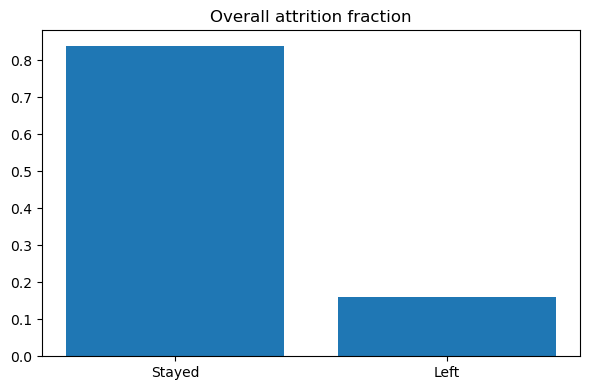

In [5]:
# EDA
print("Rows:", len(df))
print("Missing per column (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

# department if exists
dept_col = next((c for c in df.columns if c.lower() in ("department","dept","team")), None)
if dept_col:
    dept_stats = df.groupby(dept_col)["_target_attrition"].agg(['count','sum','mean']).rename(columns={'sum':'attritions','mean':'rate'})
    print("Attrition by department:\n", dept_stats.sort_values('rate', ascending=False))
    if have_display:
        display_dataframe_to_user("Dept attrition", dept_stats.reset_index())

# salary band (detect common salary columns)
salary_cols = [c for c in df.columns if c.lower() in ("monthlyincome","monthly income","salary","annualsalary","annual salary")]
if salary_cols:
    salary_col = salary_cols[0]
    df["_salary_band"] = pd.qcut(df[salary_col].fillna(df[salary_col].median()), 4, labels=["Low","Mid-Low","Mid-High","High"])
    print("Attrition by salary band:\n", df.groupby("_salary_band", observed=False)["_target_attrition"].mean())


# promotions detection
promo_col = next((c for c in df.columns if "promot" in c.lower() or "percent" in c.lower() and "hike" in c.lower()), None)
if promo_col:
    print(df.groupby(promo_col)["_target_attrition"].agg(['count','mean']).sort_values('mean', ascending=False).head(10))

# quick overall attrition plot
plt.figure(figsize=(6,4))
plt.bar(["Stayed","Left"], [1-df["_target_attrition"].mean(), df["_target_attrition"].mean()])
plt.title("Overall attrition fraction")
plt.tight_layout()
plt.show()


In [6]:
# preprocessing (generic)
drop_like = [c for c in df.columns if c.lower() in ("employeenumber","employeeid","employee number","employee id","name","employee_name","id")]
X = df.drop(columns=[target_col, "_target_attrition"] + drop_like, errors='ignore').copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# fill
for c in num_cols:
    X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    X[c] = X[c].astype(str).fillna("MISSING")

# one-hot for low-cardinality, label-encode for others
one_hot_cols = [c for c in cat_cols if X[c].nunique() <= 10]
label_encode_cols = [c for c in cat_cols if c not in one_hot_cols]

X_ohe = pd.get_dummies(X, columns=one_hot_cols, drop_first=True)
for c in label_encode_cols:
    X_ohe[c] = LabelEncoder().fit_transform(X_ohe[c].astype(str))

X_final = X_ohe.copy()
y_final = df["_target_attrition"].astype(int)

print("Final shape:", X_final.shape)


Final shape: (1470, 49)


In [7]:
# train/test, scaling, training
if y_final.nunique() < 2:
    print("Target has <2 classes — cannot meaningfully train. Check your target.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)
    scaler = StandardScaler()
    # scale numeric columns only if present
    numeric_in_X = [c for c in X_train.columns if c in num_cols]
    if numeric_in_X:
        X_train[numeric_in_X] = scaler.fit_transform(X_train[numeric_in_X])
        X_test[numeric_in_X] = scaler.transform(X_test[numeric_in_X])

    # Logistic Regression
    log = LogisticRegression(max_iter=1000)
    log.fit(X_train, y_train)
    y_pred_log = log.predict(X_test)
    print("Logistic accuracy:", accuracy_score(y_test, y_pred_log))
    print(classification_report(y_test, y_pred_log))

    # Decision Tree
    tree = DecisionTreeClassifier(max_depth=5, random_state=42)
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)
    print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_tree))
    print(classification_report(y_test, y_pred_tree))

    # save models/scaler
    joblib.dump(log, "logistic_model.joblib")
    joblib.dump(tree, "decision_tree_model.joblib")
    joblib.dump(scaler, "scaler.joblib")


Logistic accuracy: 0.8809523809523809
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       247
           1       0.75      0.38      0.51        47

    accuracy                           0.88       294
   macro avg       0.82      0.68      0.72       294
weighted avg       0.87      0.88      0.86       294

Decision Tree accuracy: 0.8299319727891157
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       247
           1       0.42      0.17      0.24        47

    accuracy                           0.83       294
   macro avg       0.64      0.56      0.57       294
weighted avg       0.79      0.83      0.80       294



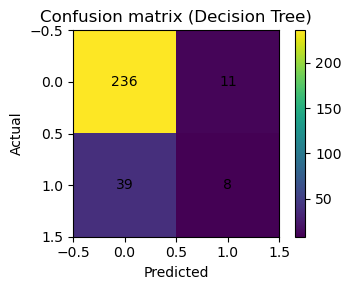

In [8]:
# confusion matrix (Decision Tree)
cm = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix (Decision Tree)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha='center', va='center')
plt.tight_layout()
plt.savefig("confusion_matrix_tree.png")   # saved for sharing
plt.show()


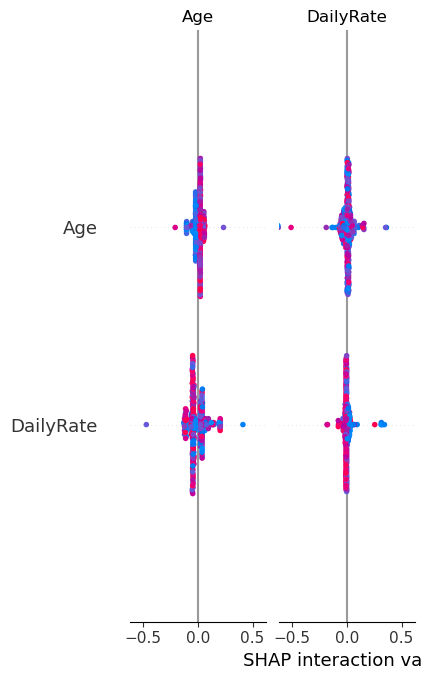

Saved shap_summary_tree.png


<Figure size 640x480 with 0 Axes>

In [9]:
# SHAP (for Decision Tree). This can be resource/time heavy; if it fails, re-run in a longer runtime.
try:
    explainer = shap.TreeExplainer(tree)
    shap_values = explainer.shap_values(X_test)
    # if binary classification shap_values is list-like; use index 1 for 'left' class
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap.summary_plot(shap_values[1], X_test, show=True)
    else:
        shap.summary_plot(shap_values, X_test, show=True)
    plt.savefig("shap_summary_tree.png", bbox_inches="tight")
    print("Saved shap_summary_tree.png")
except Exception as e:
    print("SHAP error or timeout:", e)
    print("If SHAP times out, try running only on a sample of X_test, e.g.: X_test_sample = X_test.sample(200, random_state=1)")


In [10]:
# deliverables: cleaned CSV, PDF notes, and a plain text model report
out_df = df.copy()
out_df["Attrition_binary"] = df["_target_attrition"].astype(int)
out_df.to_csv("hr_attrition_for_powerbi.csv", index=False)
print("Saved hr_attrition_for_powerbi.csv")

# PDF with suggestions
pdf_path = "attrition_prevention_suggestions.pdf"
c = canvas.Canvas(pdf_path, pagesize=A4)
width, height = A4
c.setFont("Helvetica-Bold", 14)
c.drawString(30, height-50, "HR Analytics — Attrition Prevention Suggestions")
c.setFont("Helvetica", 11)
ypos = height-80
lines = [
    "1. Strengthen onboarding & mentoring programs for new hires.",
    "2. Regular career-path discussions and transparent promotion criteria.",
    "3. Targeted salary reviews for at-risk salary bands and roles.",
    "4. Invest in manager training — poor managers drive attrition.",
    "5. Offer flexible work options and monitor workload.",
    "6. Use model + SHAP to identify individuals at risk and design interventions.",
    "7. Conduct stay interviews and pulse surveys proactively.",
]
for line in lines:
    c.drawString(30, ypos, line)
    ypos -= 16
    if ypos < 60:
        c.showPage()
        ypos = height-60
c.save()
print("Saved", pdf_path)

# Text report
report_txt = "model_accuracy_report.txt"
with open(report_txt, "w") as f:
    f.write("Model Performance Report\n\n")
    f.write("Logistic Regression:\n")
    f.write(classification_report(y_test, y_pred_log))
    f.write("\nDecision Tree:\n")
    f.write(classification_report(y_test, y_pred_tree))
print("Saved", report_txt)


Saved hr_attrition_for_powerbi.csv
Saved attrition_prevention_suggestions.pdf
Saved model_accuracy_report.txt
